In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-expression-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F99505%2F234911%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240215%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240215T100307Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D96a2f5a8b8121e5672dfca784fe6a0969a74b6c24e3fbc6e7d439a72e4fe8a97385be5b95a3a445d859cbe9fcbaf4e8f9b4d4d9d5f7e70b899c99acc64bb89e739502ef806faa93df3a28e916ec04df6978e5a1d6a86ee7a76ddeb80a68e3c575234888e32546ca4fdf33029a894f503017062ef72c71187d40c184ae2f7790abf133d80ebd9ae750ae1278519f6f6040336ad8baa2fc2ff23d8dac10908e29fdf5c15994a480655dfb1675fa5c4db9ff3f38bef306332d2a1010d6f3883d9aa793505d2a2e555a5c9790e0d1d6a208fd901e63fb0eec4ec2b59708cf58f7f51b38a3a0751a1f0865a4f97959bfd2414d01c20f50e1b27df7a3ee8c8b17ea5e7,picturesample:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4445283%2F7629618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240215%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240215T100308Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D455ded29d6d0e26201ad235ce759add89be7d3457c7531ebf033f47482e2aec8f6307e5151664f335819e24c0272b67d43c249911244129736c888f9c7daa1dda4000d85d3320446a142f52e12b2f6e5c0ea27c2bedffa91e7900266e483787ceb5f042f0879168272dae650ed9e5d6487f0484324315ef92c68499bfaec075073529e72fc90f660038985661a0f9e7fe270afd6064a12bdb8a10946b708b73d37122a4781aeaa75fc08db1a1f987eead593ac5df4fbe22596eee3b680e408e31a9c313e48fa2a6d087e4759277f342d77240bc890cea8879a3200fd31cc707f0c3af25495cb224a285ff5af927f57cc20a2a927058410c9caacd35483dae5db,sampleimagedata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4445295%2F7629633%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240215%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240215T100308Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D74f0b9a8f51a958f9279d6f3bbd62d54af055d7bf598079b5ff1a29e3d00fca23912c5da8688ad030154ed1c9912ceba309fa3aef4be1e9857f32e0547c2fe1d8c350910cf98e7ac9bc23881903c99bff5eb2fc0972fd7136bdce22092f63f8e5cb29c4dee0291b139d2097986091a82a7c638685c5db38c08f1ffc4212b3593ef8346a42e60f1f30410656c8cbe72db368673c4b29c6c755f3c16b54301ca9397dc99fc5d08406f96f1ade2443f56b21ed0ff2dbf740d5ac0684c56fe307bbcf5cc86c73ebad18b2cc1fc467b109a631fcbd9db20af0cbd5773473c8e9a6500731730307429344ee87b8faacac31020983952714cdbd6e2e09bc2178adfd3b1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
pip install Augmentor plotly

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import Augmentor
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, add, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime
from tensorflow.keras.models import load_model
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
working_directory = '/kaggle/working/'

files_and_directories = os.listdir(working_directory)

for file_or_directory in files_and_directories:
    full_path = os.path.join(working_directory, file_or_directory)

    try:
        if os.path.isfile(full_path):
            os.remove(full_path)
        elif os.path.isdir(full_path):
            shutil.rmtree(full_path)
    except Exception as e:
        print(f"Error deleting {file_or_directory}: {e}")

print(f"Contents of {working_directory} cleared.")

Contents of /kaggle/working/ cleared.


<Figure size 640x480 with 0 Axes>

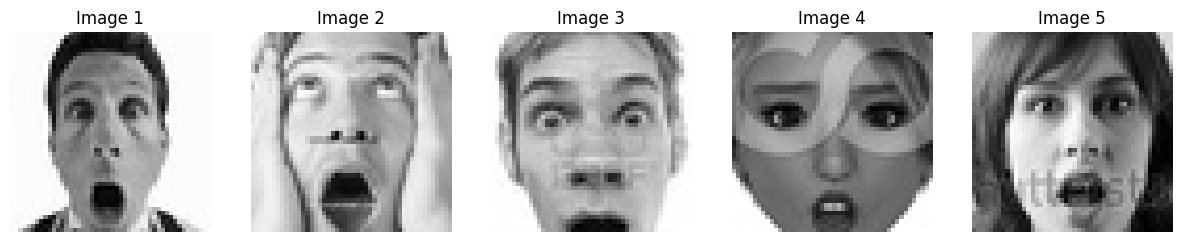

<Figure size 640x480 with 0 Axes>

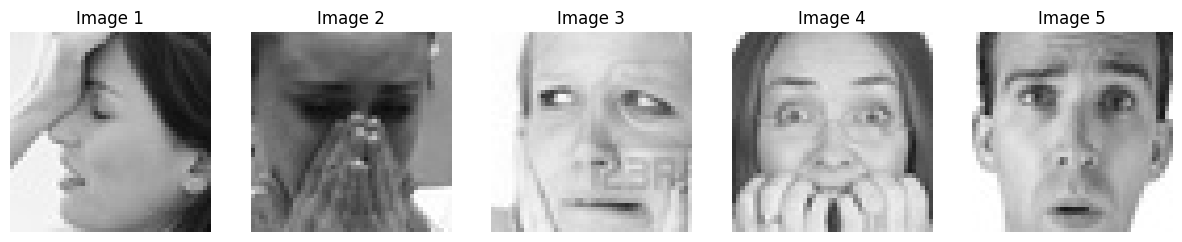

<Figure size 640x480 with 0 Axes>

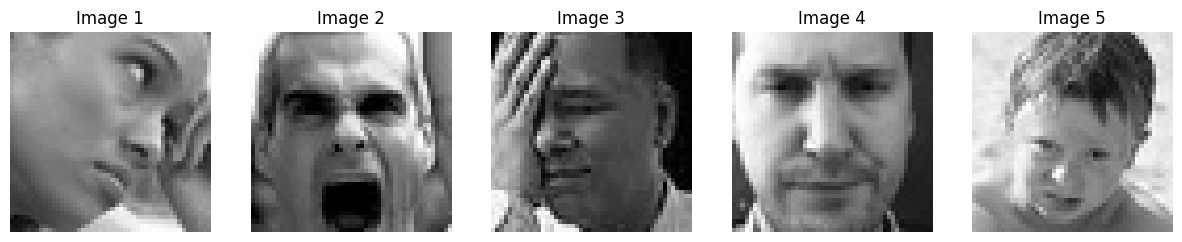

<Figure size 640x480 with 0 Axes>

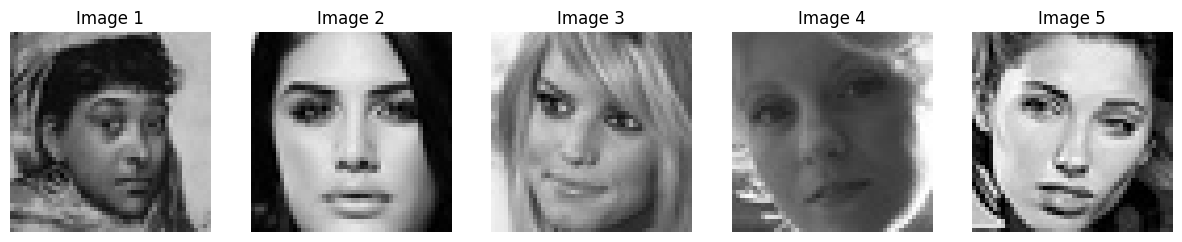

<Figure size 640x480 with 0 Axes>

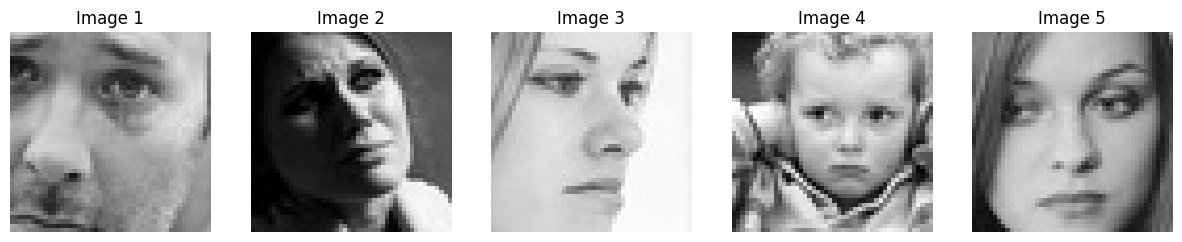

<Figure size 640x480 with 0 Axes>

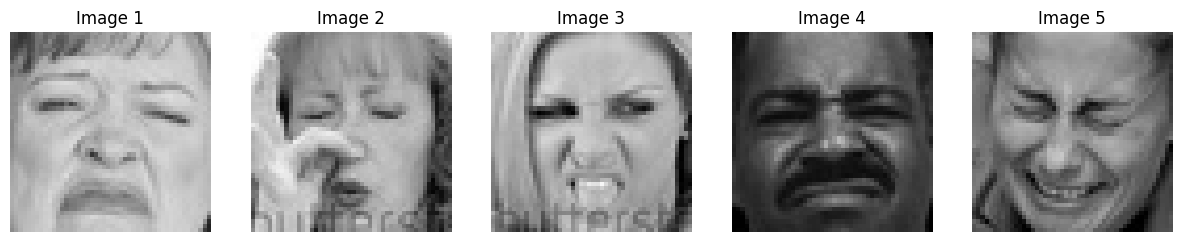

<Figure size 640x480 with 0 Axes>

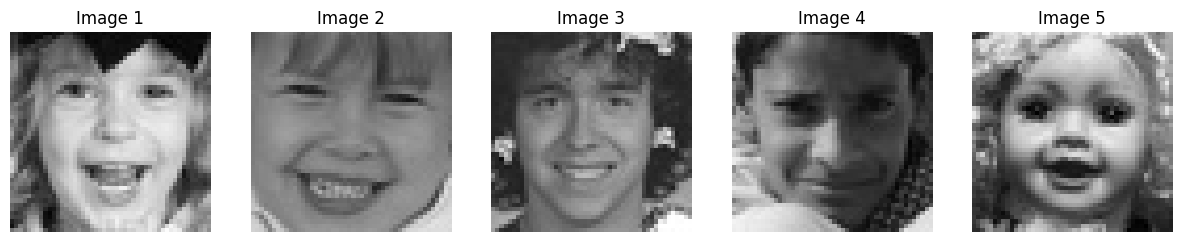

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(image_path, num_images=5):

  images = os.listdir(image_path)
  selected_images = random.sample(images, min(num_images, len(images)))

  plt.figure(figsize=(15, 8))

  for i, image_name in enumerate(selected_images, 1):
    image_path_full = os.path.join(image_path, image_name)

    # Read the image and ensure it's in RGB format before display
    img = mpimg.imread(image_path_full)
    if img.ndim == 3 and img.shape[-1] == 4:  # Check if image has alpha channel
      img = img[:, :, :3]  # Remove alpha channel
    elif img.ndim == 2:
      img = img.reshape((img.shape[0], img.shape[1], 1))  # Add single channel if grayscale
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, num_images, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i}')

  plt.show()

# Specify the path to the dataset
dataset_path = "/kaggle/input/face-expression-recognition-dataset/images/train"

# List the folders in the dataset
folders = os.listdir(dataset_path)

# Loop over the folders and display 5 images from each one
for folder in folders:
  # Get the full path to the folder
  image_path = os.path.join(dataset_path, folder)
  # Display a title for the group of images
  plt.suptitle(f'Images from {folder} folder')
  # Display 5 images from the folder
  display_images(image_path)


In [ ]:
base_path = "/kaggle/input/face-expression-recognition-dataset/images/images/"
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

3205 surprise images
4103 fear images
3993 angry images
4982 neutral images
4938 sad images
436 disgust images
7164 happy images


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
pic_size = 256
# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(pic_size, pic_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     2

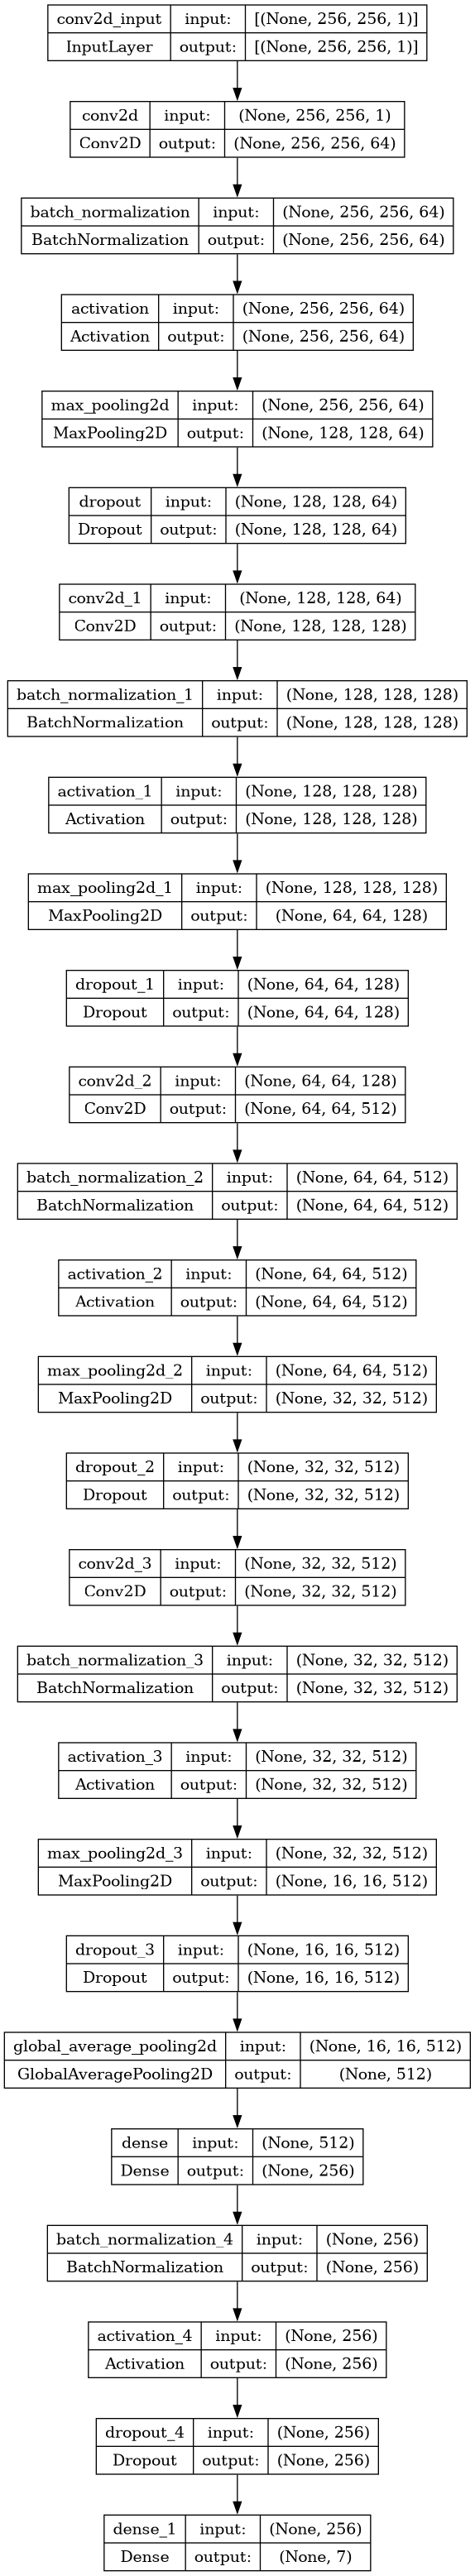

In [ ]:
plot_model(model,

           to_file='keras_model_plot.png',

           show_shapes=True,

           show_layer_names=True)

In [ ]:
%%time

# number of epochs to train the NN
epochs = 100

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

<timed exec>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100


2024-02-15 04:04:17.706209: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707969871.872480     461 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 [==============================] - 230s 884ms/step - loss: 1.9211 - accuracy: 0.2257 - val_loss: 2.0462 - val_accuracy: 0.1699
Epoch 2/100
225/225 [==============================] - 194s 862ms/step - loss: 1.8317 - accuracy: 0.2526 - val_loss: 2.1571 - val_accuracy: 0.2543
Epoch 3/100
225/225 [==============================] - 194s 864ms/step - loss: 1.7767 - accuracy: 0.2821 - val_loss: 2.2287 - val_accuracy: 0.1750
Epoch 4/100
225/225 [==============================] - 194s 863ms/step - loss: 1.7286 - accuracy: 0.3079 - val_loss: 2.3477 - val_accuracy: 0.2357
Epoch 5/100
225/225 [==============================] - 195s 864ms/step - loss: 1.6783 - accuracy: 0.3333 - val_loss: 1.7324 - val_accuracy: 0.2916
Epoch 6/100
225/225 [==============================] - 195s 864ms/step - loss: 1.6258 - accuracy: 0.3602 - val_loss: 1.6530 - val_accuracy: 0.3462
Epoch 7/100
225/225 [==============================] - 195s 865ms/step - loss: 1.5671 - accuracy: 0.3853 - val_loss: 1.8631 - val_

In [ ]:
# Save the entire model to a HDF5 file
model.save("/kaggle/working/full_model.keras")

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

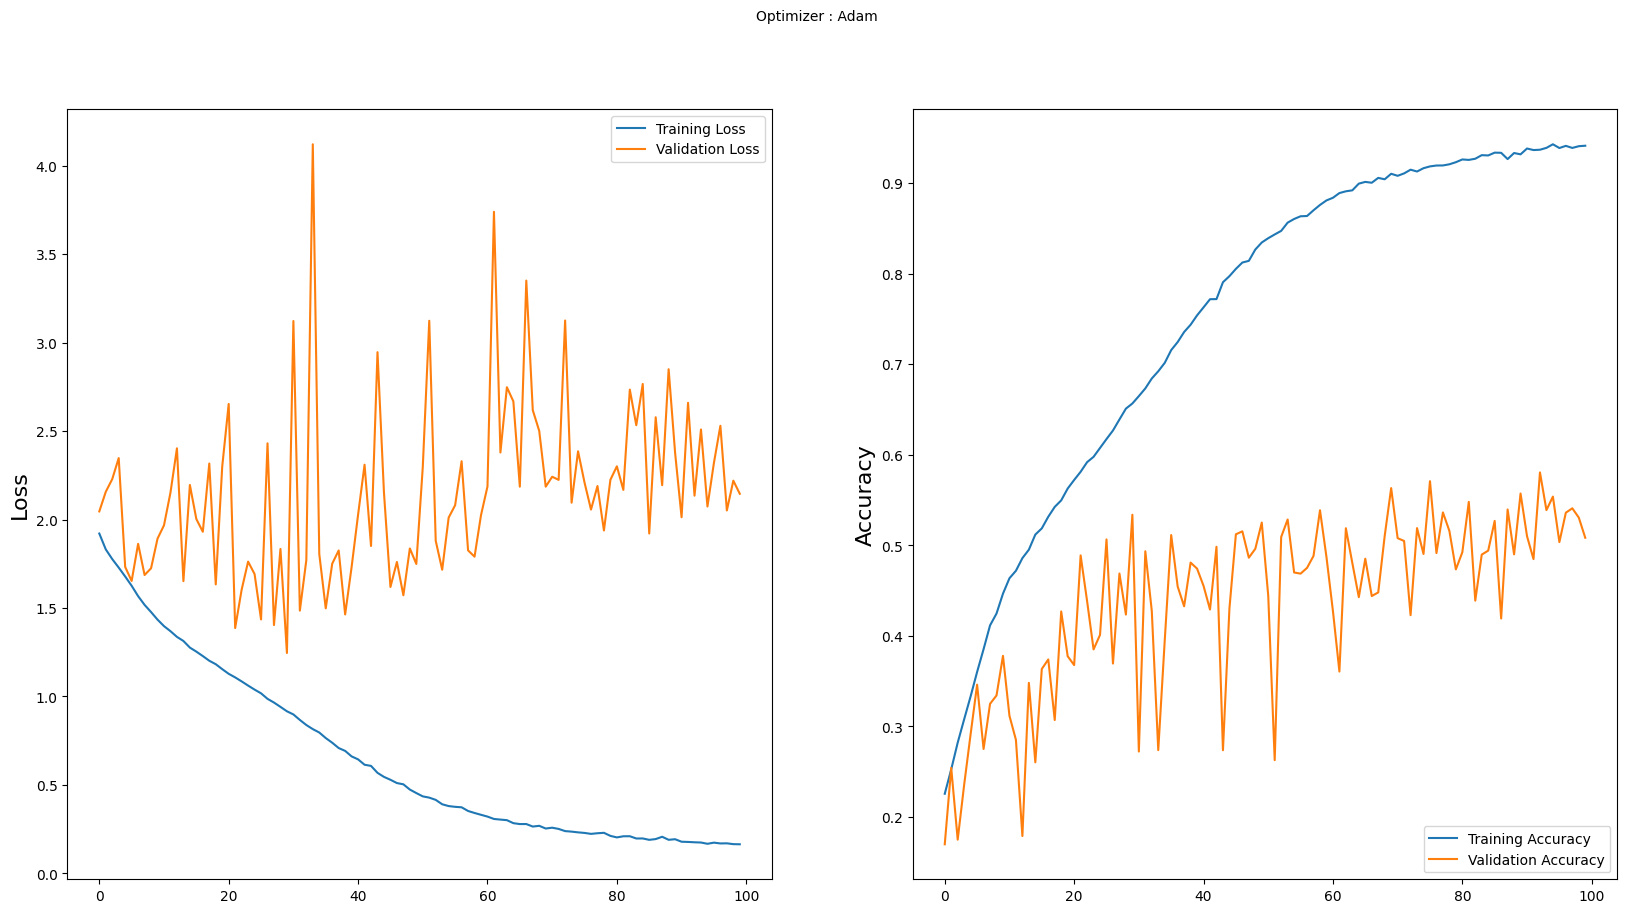

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

/tmp/ipykernel_404/3468807508.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator=validation_generator)


<Figure size 640x480 with 0 Axes>

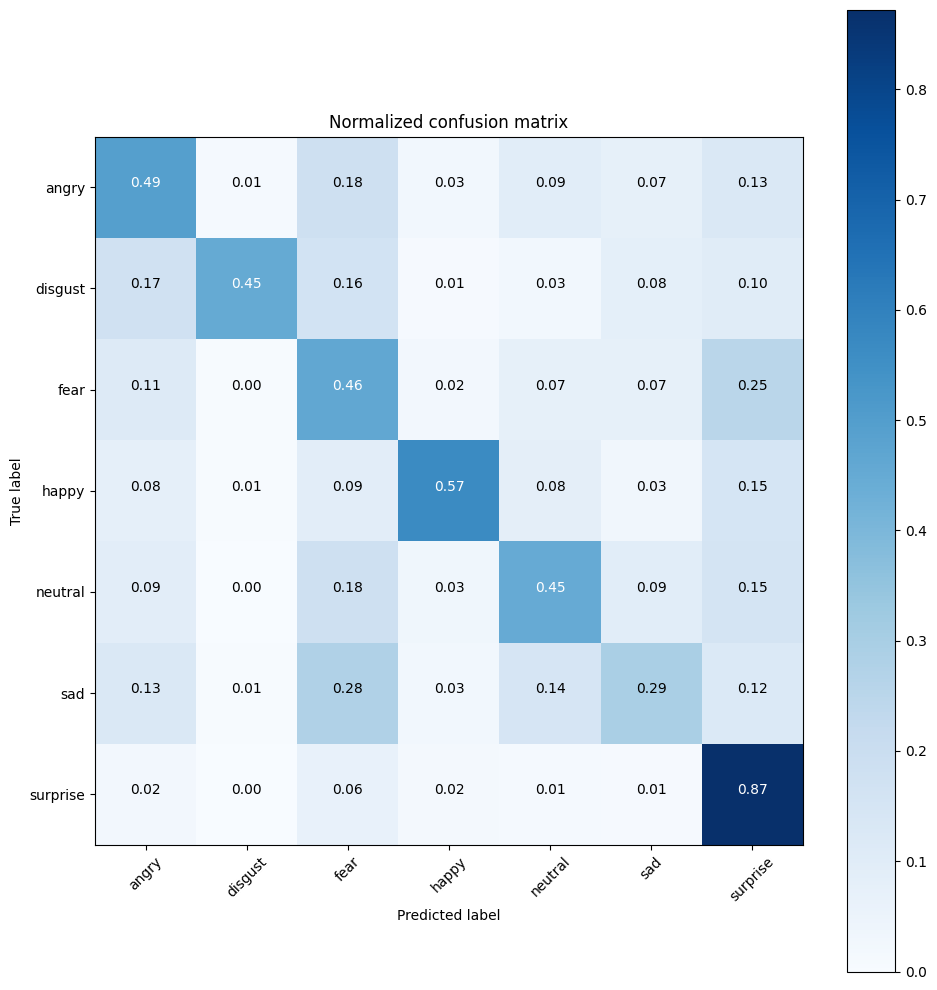

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [ ]:
print(train_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

def predict_emotion(model_path, image_path):
    # Load the saved model
    model = load_model(model_path)

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(pic_size, pic_size), grayscale=True)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the emotion
    emotion_scores = model.predict(img_array)

    # Get the predicted emotion label
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    predicted_emotion_index = np.argmax(emotion_scores)
    predicted_emotion = emotions[predicted_emotion_index]

    return predicted_emotion

**TESTING OUR MODEL-**

1/1 [==============================] - 0s 134ms/step


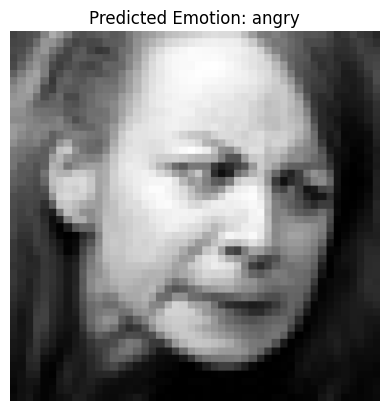

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

pic_size = 256
model_path = "/kaggle/working/full_model.keras"
image_path = "/kaggle/input/face-expression-recognition-dataset/images/validation/angry/10052.jpg"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(pic_size, pic_size), grayscale=True)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Display the image
plt.imshow(img, cmap='gray')
plt.axis('off')

# Predict the emotion
predicted_emotion = predict_emotion(model_path, image_path)  # Pass image_path instead of img_array
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.show()

1/1 [==============================] - 0s 133ms/step


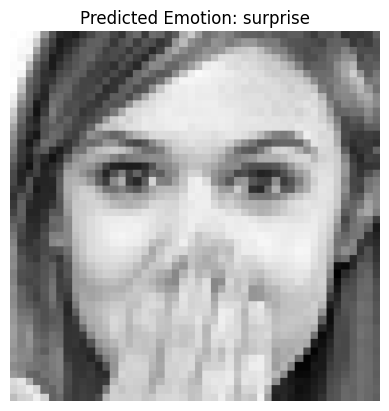

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

pic_size = 256
model_path = "/kaggle/working/full_model.keras"
image_path = "/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/10162.jpg"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(pic_size, pic_size), grayscale=True)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Display the image
plt.imshow(img, cmap='gray')
plt.axis('off')

# Predict the emotion
predicted_emotion = predict_emotion(model_path, image_path)  # Pass image_path instead of img_array
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.show()

1/1 [==============================] - 0s 132ms/step


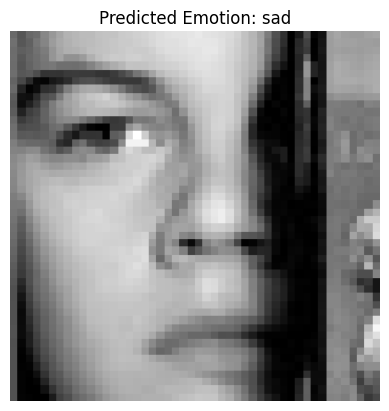

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

pic_size = 256
model_path = "/kaggle/working/full_model.keras"
image_path = "/kaggle/input/face-expression-recognition-dataset/images/validation/sad/10073.jpg"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(pic_size, pic_size), grayscale=True)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Display the image
plt.imshow(img, cmap='gray')
plt.axis('off')

# Predict the emotion
predicted_emotion = predict_emotion(model_path, image_path)  # Pass image_path instead of img_array
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.show()